In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import glob
import scipy
import re
import random
import time
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from scipy.stats import ttest_ind
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import KFold

from sklearn.model_selection import StratifiedKFold

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.optimize import minimize
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

pd.options.display.max_rows = 20
pd.options.display.float_format = "{:.3f}".format

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 8)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7
cm = 1/2.54
fig_folder = './Figure_3_exports'
data_folder = '../all_data/Figure_3_data'

# Neural network training and evaluation
### Comparison of model performance with and without protein identifiers

## Read in data

In [3]:
data = pd.read_pickle('../all_data/General_data/screen_active_data.pkl')
data

experiment_id   day  plate well_name Supp DNA_name  DNA_conc  \
0            eCM313 1.000  1.000       H12  S22     AqpZ     5.000   
1            eCM313 1.000  1.000       K12  S22     AqpZ     5.000   
2            eCM313 1.000  1.000        M5  S22     AqpZ     5.000   
3            eCM313 2.000  4.000        J2  S22     AqpZ     5.000   
4            eCM313 2.000  4.000       N22  S22     AqpZ     5.000   
...             ...   ...    ...       ...  ...      ...       ...   
33542        eCM313 2.000  3.000        A1  S22      Vol     5.000   
33543        eCM313 2.000  4.000        B2  S22      Vol     5.000   
33544        eCM313 2.000  4.000        B2  S22      Vol     5.000   
33545        eCM313 2.000  4.000        G6  S22      Vol     5.000   
33546        eCM313 2.000  4.000        G6  S22      Vol     5.000   

      Liposome_name  Liposome_conc     Mg  SecYE    K   WCE   PEG  pmol  \
0              DMPC              3  8.000  0.000   85  BL62 2.000 4.918   
1              DMPC              3  8.000  0.000   85  BL62 2.000 4.311   
2              DMPC              3  8.000  0.000   85  BL62 2.000 2.644   
3              DMPC              3  8.000  0.000   85  BL62 2.000 7.546   
4              DMPC              3  8.000  0.000   85  BL62 2.000 7.527   
...             ...            ...    ...    ...  ...   ...   ...   ...   
33542       no_lipo              0 20.000  1.250  135  BL62 2.000 1.149   
33543       no_lipo              0 20.000  1.250  135  BL62 2.000 1.265   
33544       no_lipo              0 20.000  1.250  135  BL62 2.000 1.265   
33545       no_lipo              0 20.000  1.250  135  BL62 2.000 2.024   
33546       no_lipo              0 20.000  1.250  135  BL62 2.000 2.024   

        rxn_id   label  
0        0.000  screen  
1        0.000  screen  
2        0.000  screen  
3        0.000  screen  
4        0.000  screen  
...        ...     ...  
33542 3966.000  screen  
33543 3862.000  screen  
33544 3966.000  screen  
33545 3862.000  screen  
33546 3966.000  screen  

[11197 rows x 17 columns]

In [4]:
sub_df = []

for rxn_id,rxn_df in data.groupby('rxn_id'):
    lipo = rxn_df[rxn_df['Liposome_conc'] != 0].copy()
    nolipo = rxn_df[rxn_df['Liposome_conc'] == 0].copy()
    nolipo_mean = np.mean(nolipo['pmol'])
    if len(nolipo) == 0:
        print(rxn_id)
        continue
    lipo['pmol_sub'] = lipo['pmol'] - nolipo_mean
    nolipo['pmol_sub'] = nolipo['pmol'] - nolipo_mean
    
    sub_df.append(lipo)
    sub_df.append(nolipo)
    
sub_df = pd.concat(sub_df)
sub_df

experiment_id   day  plate well_name Supp DNA_name  DNA_conc  \
0            eCM313 1.000  1.000       H12  S22     AqpZ     5.000   
1            eCM313 1.000  1.000       K12  S22     AqpZ     5.000   
2            eCM313 1.000  1.000        M5  S22     AqpZ     5.000   
3            eCM313 2.000  4.000        J2  S22     AqpZ     5.000   
4            eCM313 2.000  4.000       N22  S22     AqpZ     5.000   
...             ...   ...    ...       ...  ...      ...       ...   
33538        eCM313 1.000  2.000       C22  S22      Vol     5.000   
33540        eCM313 1.000  2.000       N11  S22      Vol     5.000   
33542        eCM313 2.000  3.000        A1  S22      Vol     5.000   
33544        eCM313 2.000  4.000        B2  S22      Vol     5.000   
33546        eCM313 2.000  4.000        G6  S22      Vol     5.000   

      Liposome_name  Liposome_conc     Mg  SecYE    K   WCE   PEG  pmol  \
0              DMPC              3  8.000  0.000   85  BL62 2.000 4.918   
1              DMPC              3  8.000  0.000   85  BL62 2.000 4.311   
2              DMPC              3  8.000  0.000   85  BL62 2.000 2.644   
3              DMPC              3  8.000  0.000   85  BL62 2.000 7.546   
4              DMPC              3  8.000  0.000   85  BL62 2.000 7.527   
...             ...            ...    ...    ...  ...   ...   ...   ...   
33538       no_lipo              0 20.000  1.250  135  BL62 2.000 1.915   
33540       no_lipo              0 20.000  1.250  135  BL62 2.000 1.529   
33542       no_lipo              0 20.000  1.250  135  BL62 2.000 1.149   
33544       no_lipo              0 20.000  1.250  135  BL62 2.000 1.265   
33546       no_lipo              0 20.000  1.250  135  BL62 2.000 2.024   

        rxn_id   label  pmol_sub  
0        0.000  screen     2.688  
1        0.000  screen     2.081  
2        0.000  screen     0.414  
3        0.000  screen     5.316  
4        0.000  screen     5.297  
...        ...     ...       ...  
33538 3966.000  screen     0.238  
33540 3966.000  screen    -0.148  
33542 3966.000  screen    -0.529  
33544 3966.000  screen    -0.413  
33546 3966.000  screen     0.347  

[11197 rows x 18 columns]

### Organize all reaction variables and convert the categorical variables

In [5]:
training_data = sub_df.copy()
training_data = training_data[training_data['label'] == 'screen'].copy()
training_data = training_data[training_data['Liposome_name'] != 'no_lipo'].copy()


lipo_dict = {'DOPC':18,'DPPC':16,'DMPC':14,'no_lipo':0}

training_data['lipid'] = training_data['Liposome_name'].apply(lambda x: lipo_dict[x])
training_data = training_data[['rxn_id','DNA_name','lipid','Mg','SecYE','K','PEG','pmol','pmol_sub']].copy()
training_data

rxn_id DNA_name  lipid     Mg  SecYE    K   PEG  pmol  pmol_sub
0        0.000     AqpZ     14  8.000  0.000   85 2.000 4.918     2.688
1        0.000     AqpZ     14  8.000  0.000   85 2.000 4.311     2.081
2        0.000     AqpZ     14  8.000  0.000   85 2.000 2.644     0.414
3        0.000     AqpZ     14  8.000  0.000   85 2.000 7.546     5.316
4        0.000     AqpZ     14  8.000  0.000   85 2.000 7.527     5.297
...        ...      ...    ...    ...    ...  ...   ...   ...       ...
15746 3966.000      Vol     18 20.000  1.250  135 2.000 1.240    -0.438
15747 3966.000      Vol     18 20.000  1.250  135 2.000 1.230    -0.447
15748 3966.000      Vol     18 20.000  1.250  135 2.000 1.726     0.048
15749 3966.000      Vol     18 20.000  1.250  135 2.000 1.145    -0.532
15750 3966.000      Vol     18 20.000  1.250  135 2.000 0.972    -0.705

[4148 rows x 9 columns]

### Convert the protein names into unique columns for each protein using OneHot encoding

In [6]:
def add_one_hot(df,col_name):
    temp = df[[col_name]]

    one_hot_encoder = OneHotEncoder(sparse_output=False)
    one_hot_encoder.fit(temp)

    encoded = one_hot_encoder.transform(temp)
    encoded = pd.DataFrame(data=encoded, columns=[col_name+'-'+c for c in one_hot_encoder.categories_])
    df = df.join(encoded)
    targets = list([col_name+'-'+c for c in one_hot_encoder.categories_])[0]
    original = [(t,) for t in targets]
    df = df.rename(columns=dict(zip(original,targets)))
    return df


prot_feat = training_data[['DNA_name']].drop_duplicates().reset_index(drop=True)
dna_encoded = add_one_hot(prot_feat,'DNA_name')

dna_encoded.columns

Index(['DNA_name', 'DNA_name-AqpZ', 'DNA_name-Aux', 'DNA_name-B2AR',
       'DNA_name-B3AR', 'DNA_name-Beta', 'DNA_name-CD47', 'DNA_name-CD63',
       'DNA_name-CD81', 'DNA_name-CD9', 'DNA_name-CML1', 'DNA_name-CRCM',
       'DNA_name-CaM', 'DNA_name-Cx43', 'DNA_name-Dia', 'DNA_name-FFAR4',
       'DNA_name-Glut', 'DNA_name-InP', 'DNA_name-Mito', 'DNA_name-Mol',
       'DNA_name-MscL', 'DNA_name-MtlA', 'DNA_name-Neu', 'DNA_name-OR1A1',
       'DNA_name-OR1D2', 'DNA_name-OR1E1', 'DNA_name-OR2AG1',
       'DNA_name-SecYE-G', 'DNA_name-Vol'],
      dtype='object')

In [7]:
all_features = training_data.set_index('DNA_name').join(dna_encoded.set_index('DNA_name')).reset_index()
all_features

DNA_name   rxn_id  lipid     Mg  SecYE    K   PEG  pmol  pmol_sub  \
0        AqpZ    0.000     14  8.000  0.000   85 2.000 4.918     2.688   
1        AqpZ    0.000     14  8.000  0.000   85 2.000 4.311     2.081   
2        AqpZ    0.000     14  8.000  0.000   85 2.000 2.644     0.414   
3        AqpZ    0.000     14  8.000  0.000   85 2.000 7.546     5.316   
4        AqpZ    0.000     14  8.000  0.000   85 2.000 7.527     5.297   
...       ...      ...    ...    ...    ...  ...   ...   ...       ...   
4143      Vol 3966.000     18 20.000  1.250  135 2.000 1.240    -0.438   
4144      Vol 3966.000     18 20.000  1.250  135 2.000 1.230    -0.447   
4145      Vol 3966.000     18 20.000  1.250  135 2.000 1.726     0.048   
4146      Vol 3966.000     18 20.000  1.250  135 2.000 1.145    -0.532   
4147      Vol 3966.000     18 20.000  1.250  135 2.000 0.972    -0.705   

      DNA_name-AqpZ  ...  DNA_name-Mol  DNA_name-MscL  DNA_name-MtlA  \
0             1.000  ...         0.000          0.000          0.000   
1             1.000  ...         0.000          0.000          0.000   
2             1.000  ...         0.000          0.000          0.000   
3             1.000  ...         0.000          0.000          0.000   
4             1.000  ...         0.000          0.000          0.000   
...             ...  ...           ...            ...            ...   
4143          0.000  ...         0.000          0.000          0.000   
4144          0.000  ...         0.000          0.000          0.000   
4145          0.000  ...         0.000          0.000          0.000   
4146          0.000  ...         0.000          0.000          0.000   
4147          0.000  ...         0.000          0.000          0.000   

      DNA_name-Neu  DNA_name-OR1A1  DNA_name-OR1D2  DNA_name-OR1E1  \
0            0.000           0.000           0.000           0.000   
1            0.000           0.000           0.000           0.000   
2            0.000           0.000           0.000           0.000   
3            0.000           0.000           0.000           0.000   
4            0.000           0.000           0.000           0.000   
...            ...             ...             ...             ...   
4143         0.000           0.000           0.000           0.000   
4144         0.000           0.000           0.000           0.000   
4145         0.000           0.000           0.000           0.000   
4146         0.000           0.000           0.000           0.000   
4147         0.000           0.000           0.000           0.000   

      DNA_name-OR2AG1  DNA_name-SecYE-G  DNA_name-Vol  
0               0.000             0.000         0.000  
1               0.000             0.000         0.000  
2               0.000             0.000         0.000  
3               0.000             0.000         0.000  
4               0.000             0.000         0.000  
...               ...               ...           ...  
4143            0.000             0.000         1.000  
4144            0.000             0.000         1.000  
4145            0.000             0.000         1.000  
4146            0.000             0.000         1.000  
4147            0.000             0.000         1.000  

[4148 rows x 37 columns]

### Min-Max scaling reaction condition variables

In [8]:
data_bounded = all_features[['Mg', 'SecYE', 'K', 'PEG','lipid']]
X_bounded = np.array(data_bounded)
MMscalerX = MinMaxScaler()
X_bounded = MMscalerX.fit_transform(X_bounded)
data_bounded = pd.DataFrame(X_bounded,columns=data_bounded.columns)
data_bounded['rxn_id'] = all_features['rxn_id']
data_bounded = data_bounded.drop_duplicates().set_index('rxn_id')
data_bounded

Mg  SecYE     K   PEG  lipid
rxn_id                                  
0.000    0.000  0.000 0.000 1.000  0.000
2.000    0.000  0.000 0.000 1.000  0.000
3.000    0.000  0.000 0.500 1.000  0.000
7.000    0.000  0.000 1.000 0.500  0.000
9.000    0.000  1.000 0.000 1.000  0.000
...        ...    ...   ...   ...    ...
3944.000 0.667  1.000 0.500 1.000  1.000
3949.000 1.000  0.000 0.000 1.000  1.000
3953.000 1.000  0.000 0.500 1.000  1.000
3965.000 1.000  1.000 0.000 1.000  1.000
3966.000 1.000  1.000 0.500 1.000  1.000

[924 rows x 5 columns]

### Standard Scaling
* Calculates the z-scored values for each protein to capture the relative impact of reaction conditions on each protein rather than the overall yield of the protein.
* Normalizes both the raw pmol value and the no liposome subtracted out pmol values
* All final models, however, use the raw pmol values for training

In [9]:
y_col = 'pmol'

transformed = []
scaler_dict = {}

for dna, dna_df in all_features.groupby('DNA_name'):
    temp = dna_df.copy()
    y_scaled = np.array(dna_df[[y_col]])
    scalerY = StandardScaler()
    y_scaled = scalerY.fit_transform(y_scaled)
    temp['label'] = y_scaled
    transformed.append(temp)
    scaler_dict.update({dna:scalerY})
transformed = pd.concat(transformed)
transformed = transformed[['rxn_id','label']].set_index('rxn_id')
transformed

label
rxn_id         
0.000    -0.178
0.000    -0.387
0.000    -0.963
0.000     0.730
0.000     0.723
...         ...
3966.000 -0.736
3966.000 -0.773
3966.000  1.096
3966.000 -1.093
3966.000 -1.745

[4148 rows x 1 columns]

In [10]:
y_col = 'pmol_sub'

transformed_sub = []
scaler_dict_sub = {}

for dna, dna_df in all_features.groupby('DNA_name'):
    temp = dna_df.copy()
    y_scaled = np.array(dna_df[[y_col]])
    scalerY = StandardScaler()
    y_scaled = scalerY.fit_transform(y_scaled)
    temp['label_sub'] = y_scaled
    transformed_sub.append(temp)
    scaler_dict_sub.update({dna:scalerY})
transformed_sub = pd.concat(transformed_sub)
transformed_sub = transformed_sub[['rxn_id','label_sub']].set_index('rxn_id')
transformed_sub['label'] = transformed['label']
transformed_sub

label_sub  label
rxn_id                    
0.000        -0.221 -0.178
0.000        -0.474 -0.387
0.000        -1.169 -0.963
0.000         0.875  0.730
0.000         0.867  0.723
...             ...    ...
3966.000      0.434 -0.736
3966.000      0.403 -0.773
3966.000      1.970  1.096
3966.000      0.135 -1.093
3966.000     -0.412 -1.745

[4148 rows x 2 columns]

In [11]:
encoded_cols = [c for c in all_features.columns if '-' in c]
encoded_cols = all_features[encoded_cols+['rxn_id','DNA_name']].drop_duplicates().set_index('rxn_id')
encoded_cols

DNA_name-AqpZ  DNA_name-Aux  DNA_name-B2AR  DNA_name-B3AR  \
rxn_id                                                                
0.000             1.000         0.000          0.000          0.000   
2.000             1.000         0.000          0.000          0.000   
3.000             1.000         0.000          0.000          0.000   
7.000             1.000         0.000          0.000          0.000   
9.000             1.000         0.000          0.000          0.000   
...                 ...           ...            ...            ...   
3944.000          0.000         0.000          0.000          0.000   
3949.000          0.000         0.000          0.000          0.000   
3953.000          0.000         0.000          0.000          0.000   
3965.000          0.000         0.000          0.000          0.000   
3966.000          0.000         0.000          0.000          0.000   

          DNA_name-Beta  DNA_name-CD47  DNA_name-CD63  DNA_name-CD81  \
rxn_id                                                                 
0.000             0.000          0.000          0.000          0.000   
2.000             0.000          0.000          0.000          0.000   
3.000             0.000          0.000          0.000          0.000   
7.000             0.000          0.000          0.000          0.000   
9.000             0.000          0.000          0.000          0.000   
...                 ...            ...            ...            ...   
3944.000          0.000          0.000          0.000          0.000   
3949.000          0.000          0.000          0.000          0.000   
3953.000          0.000          0.000          0.000          0.000   
3965.000          0.000          0.000          0.000          0.000   
3966.000          0.000          0.000          0.000          0.000   

          DNA_name-CD9  DNA_name-CML1  ...  DNA_name-MscL  DNA_name-MtlA  \
rxn_id                                 ...                                 
0.000            0.000          0.000  ...          0.000          0.000   
2.000            0.000          0.000  ...          0.000          0.000   
3.000            0.000          0.000  ...          0.000          0.000   
7.000            0.000          0.000  ...          0.000          0.000   
9.000            0.000          0.000  ...          0.000          0.000   
...                ...            ...  ...            ...            ...   
3944.000         0.000          0.000  ...          0.000          0.000   
3949.000         0.000          0.000  ...          0.000          0.000   
3953.000         0.000          0.000  ...          0.000          0.000   
3965.000         0.000          0.000  ...          0.000          0.000   
3966.000         0.000          0.000  ...          0.000          0.000   

          DNA_name-Neu  DNA_name-OR1A1  DNA_name-OR1D2  DNA_name-OR1E1  \
rxn_id                                                                   
0.000            0.000           0.000           0.000           0.000   
2.000            0.000           0.000           0.000           0.000   
3.000            0.000           0.000           0.000           0.000   
7.000            0.000           0.000           0.000           0.000   
9.000            0.000           0.000           0.000           0.000   
...                ...             ...             ...             ...   
3944.000         0.000           0.000           0.000           0.000   
3949.000         0.000           0.000           0.000           0.000   
3953.000         0.000           0.000           0.000           0.000   
3965.000         0.000           0.000           0.000           0.000   
3966.000         0.000           0.000           0.000           0.000   

          DNA_name-OR2AG1  DNA_name-SecYE-G  DNA_name-Vol  DNA_name  
rxn_id                                                               
0.000               0.000             0.000         0.000

In [12]:
norm_data = transformed_sub.join(data_bounded).join(encoded_cols).reset_index()
norm_data

rxn_id  label_sub  label    Mg  SecYE     K   PEG  lipid  \
0       0.000     -0.221 -0.178 0.000  0.000 0.000 1.000  0.000   
1       0.000     -0.474 -0.387 0.000  0.000 0.000 1.000  0.000   
2       0.000     -1.169 -0.963 0.000  0.000 0.000 1.000  0.000   
3       0.000      0.875  0.730 0.000  0.000 0.000 1.000  0.000   
4       0.000      0.867  0.723 0.000  0.000 0.000 1.000  0.000   
...       ...        ...    ...   ...    ...   ...   ...    ...   
4143 3966.000      0.434 -0.736 1.000  1.000 0.500 1.000  1.000   
4144 3966.000      0.403 -0.773 1.000  1.000 0.500 1.000  1.000   
4145 3966.000      1.970  1.096 1.000  1.000 0.500 1.000  1.000   
4146 3966.000      0.135 -1.093 1.000  1.000 0.500 1.000  1.000   
4147 3966.000     -0.412 -1.745 1.000  1.000 0.500 1.000  1.000   

      DNA_name-AqpZ  DNA_name-Aux  ...  DNA_name-MscL  DNA_name-MtlA  \
0             1.000         0.000  ...          0.000          0.000   
1             1.000         0.000  ...          0.000          0.000   
2             1.000         0.000  ...          0.000          0.000   
3             1.000         0.000  ...          0.000          0.000   
4             1.000         0.000  ...          0.000          0.000   
...             ...           ...  ...            ...            ...   
4143          0.000         0.000  ...          0.000          0.000   
4144          0.000         0.000  ...          0.000          0.000   
4145          0.000         0.000  ...          0.000          0.000   
4146          0.000         0.000  ...          0.000          0.000   
4147          0.000         0.000  ...          0.000          0.000   

      DNA_name-Neu  DNA_name-OR1A1  DNA_name-OR1D2  DNA_name-OR1E1  \
0            0.000           0.000           0.000           0.000   
1            0.000           0.000           0.000           0.000   
2            0.000           0.000           0.000           0.000   
3            0.000           0.000           0.000           0.000   
4            0.000           0.000           0.000           0.000   
...            ...             ...             ...             ...   
4143         0.000           0.000           0.000           0.000   
4144         0.000           0.000           0.000           0.000   
4145         0.000           0.000           0.000           0.000   
4146         0.000           0.000           0.000           0.000   
4147         0.000           0.000           0.000           0.000   

      DNA_name-OR2AG1  DNA_name-SecYE-G  DNA_name-Vol  DNA_name  
0               0.000             0.000         0.000      AqpZ  
1               0.000             0.000         0.000      AqpZ  
2               0.000             0.000         0.000      AqpZ  
3               0.000             0.000         0.000      AqpZ  
4               0.000             0.000         0.000      AqpZ  
...               ...               ...           ...       ...  
4143            0.000             0.000         1.000       Vol  
4144            0.000             0.000         1.000       Vol  
4145            0.000             0.000         1.000       Vol  
4146            0.000             0.000         1.000       Vol  
4147            0.000             0.000         1.000       Vol  

[4148 rows x 37 columns]

### Design feature sets for ensembles
* Here is where the features included in the input layer of the neural network are set. 
* Any modification to the inputs are defined as new ensembles and all the column names for the included data need to be combined as a single list
* This could include protein metadata like their length, organism of origin, etc. 

In [13]:
rxn_features = ['Mg','SecYE','K','PEG','lipid']
dna_features = [c for c in norm_data.columns if 'DNA_name-' in c]


In [14]:
col_dict = {
    'no_prot_features':rxn_features,
    'dna_encoded':rxn_features+dna_features,
}

### Specification of the model architecture
* The neural network implemented here is a simple sequential neural network
* The input layer is dynamically generated to match the input data
* The other layers are Densely connected layers which are defined by a number of node and an activation function
* The make_model function takes in a list of nodes that will be used to define all the hidden layers
* All models have a single node output layer that uses a linear activation function
* All models also use Adam optimization method

In [15]:
def make_model(learning_rate=1e-3,nodes=[256,128,64,32,16],loss='mean_absolute_error'):
    temp = [tf.keras.layers.Dense(n, activation='relu') for n in nodes] + [tf.keras.layers.Dense(1, activation="linear")]
    model = tf.keras.Sequential([*temp])
    
    model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    return model

def prep_data(train,test,target='label'):
    to_drop = 'rxn_id'
    train = train.drop(columns=to_drop)
    test = test.drop(columns=to_drop)
    
    cols = [col for col in train.columns.values if col not in ['label','label_sub']]
    print('Current target label:',target)
    X_train = np.array(train[cols])
    y_train = train[target].values.reshape(-1, 1)

    X_test = np.array(test[cols])
    y_test = test[target].values.reshape(-1, 1)
    
    return train,test,X_train,X_test,y_train,y_test

### Defines the parameters to change in each model of the ensemble
* Specifies the number of hidden layers and the number of nodes in each layer
* Defines the learning rate and batch sizes
* Whether to use the raw pmol value (label) or the subtracted pmol value (label_sub)
* Defines the loss metric
* Defines the number of ways to split the data (folds)
    * The folds are designed so that the every reaction composition ends up in only one test set
    * If the number of folds is set to 5 then the algorithm will generate 5x 80:20 train:test data splits
    * The test and training data keeps all replicate reactions within the same set
* The algorithm then makes all combinations of these variables to make a new dataframe to coordinate the training of all models in each ensemble. 

In [30]:

layer_arr = []
num_layers = [4,5,6]

nodes = [2**i for i in range(4,12)][::-1]
start = 'low'
for num in num_layers:
    if start == 'high':
        layers = [nodes[i] for i in range(num)]
    elif start == 'low':
        layers = [nodes[len(nodes)-i-1] for i in range(num)][::-1]
    layer_arr.append(layers)

learning_rates = [1e-3]
batch_sizes = [10,50,200]

ensemble = ['no_prot_features','dna_encoded']
# ensemble = ['no_prot_features']

# loss_metrics = ['mean_absolute_error','mean_squared_error']
loss_metrics = ['mean_squared_error']

# label_names = ['label','label_sub']
label_names = ['label']


folds = range(5)

combinations = list(itertools.product(ensemble,loss_metrics,label_names,folds,batch_sizes,learning_rates,layer_arr))
combinations = pd.DataFrame(combinations,columns=['ensemble','loss','label_type','fold','batch','learning_rate','nodes']).reset_index().rename(columns={'index':'model_id'}).set_index('model_id')
combinations = combinations.reset_index()
combinations['cols'] = combinations['ensemble'].apply(lambda x: col_dict[x])
combinations


def partition (list_in, n,random_seed=0):
    random.Random(random_seed).shuffle(list_in)
    return [[i,list_in[i::n]] for i in range(n)]

def get_train_ids(test_ids,available_ids):
    return [i for i in available_ids if i not in test_ids]

subset_ids = norm_data['rxn_id'].drop_duplicates().tolist()
test_ids = partition(subset_ids,len(folds))
test_ids = pd.DataFrame(test_ids,columns=['fold','test_ids'])
test_ids['train_ids'] = test_ids['test_ids'].apply(get_train_ids,available_ids=subset_ids)
    
combinations = combinations.set_index('fold').join(test_ids.set_index('fold')).reset_index()

combinations

fold  model_id          ensemble                loss label_type  batch  \
0      0         0  no_prot_features  mean_squared_error      label     10   
1      0         1  no_prot_features  mean_squared_error      label     10   
2      0         2  no_prot_features  mean_squared_error      label     10   
3      0         3  no_prot_features  mean_squared_error      label     50   
4      0         4  no_prot_features  mean_squared_error      label     50   
..   ...       ...               ...                 ...        ...    ...   
85     4        85       dna_encoded  mean_squared_error      label     50   
86     4        86       dna_encoded  mean_squared_error      label     50   
87     4        87       dna_encoded  mean_squared_error      label    200   
88     4        88       dna_encoded  mean_squared_error      label    200   
89     4        89       dna_encoded  mean_squared_error      label    200   

    learning_rate                        nodes  \
0           0.001            [128, 64, 32, 16]   
1           0.001       [256, 128, 64, 32, 16]   
2           0.001  [512, 256, 128, 64, 32, 16]   
3           0.001            [128, 64, 32, 16]   
4           0.001       [256, 128, 64, 32, 16]   
..            ...                          ...   
85          0.001       [256, 128, 64, 32, 16]   
86          0.001  [512, 256, 128, 64, 32, 16]   
87          0.001            [128, 64, 32, 16]   
88          0.001       [256, 128, 64, 32, 16]   
89          0.001  [512, 256, 128, 64, 32, 16]   

                                                 cols  \
0                          [Mg, SecYE, K, PEG, lipid]   
1                          [Mg, SecYE, K, PEG, lipid]   
2                          [Mg, SecYE, K, PEG, lipid]   
3                          [Mg, SecYE, K, PEG, lipid]   
4                          [Mg, SecYE, K, PEG, lipid]   
..                                                ...   
85  [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
86  [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
87  [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
88  [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
89  [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   

                                             test_ids  \
0   [2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....   
1   [2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....   
2   [2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....   
3   [2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....   
4   [2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....   
..                                                ...   
85  [1849.0, 475.0, 1020.0, 2984.0, 2342.0, 3851.0...   
86  [1849.0, 475.0, 1020.0, 2984.0, 2342.0, 3851.0...   
87  [1849.0, 475.0, 1020.0, 2984.0, 2342.0, 3851.0...   
88  [1849.0, 475.0, 1020.0, 2984.0, 2342.0, 3851.0...   
89  [1849.0, 475.0, 1020.0, 2984.0, 2342.0, 3851.0...   

                                            train_ids  
0   [2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060....  
1   [2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060....  
2   [2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060....  
3   [2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060....  
4   [2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060....  
..                                                ...  
85  [2999.0, 2744.0, 2680.0, 3314.0, 1542.0, 2037....  
86  [2999.0, 2744.0, 2680.0, 3314.0, 1542.0, 2037....  
87  [2999.0, 2744.0, 2680.0, 3314.0, 1542.0, 2037....  
88  [2999.0, 2744.0, 2680.0, 3314.0, 1542.0, 2037....  
89  [2999.0, 2744.0, 2680.0, 3314.0, 1542.0, 2037....  

[90 rows x 11 columns]

### Train all the models
* Each iteration uses all the parameters specified by the row in the combinations dataframe
* A directory is created to store all models created based on the defined combinations
* Each complete training run is saved before the algorithm moves to the next model
* The model specification is stored in the model_id_info file that is saved in the top level directory

In [ ]:
time_start = time.strftime("%Y-%m-%d_%H-%M", time.gmtime())

dir_path = '../all_data/Figure_3_data/protein_id_comparison_models'


if not os.path.exists(dir_path):
    os.makedirs(dir_path)
else:
    print('Directory already exists - Overwriting data')
    
combinations.to_pickle(f'{dir_path}/model_id_info.pkl')

    
EPOCHS = 100

for i,row in combinations.iterrows():
    if os.path.exists(f'{dir_path}/model-{row.model_id}.keras'):
        print(f'{dir_path}/model-{row.model_id} already trained')
        continue
    print(f'\n\n{row.model_id}:{row.loss}-{row.label_type} {round(i/len(combinations)*100,1)}%, ensemble: {row.ensemble}, nodes: {row.nodes}')
        
    t = norm_data[row.cols + ['rxn_id',row.label_type]]
    train = t[t['rxn_id'].isin(row['train_ids'])]
    test = t[t['rxn_id'].isin(row['test_ids'])]
    
    train,test,X_train,X_test,y_train,y_test = prep_data(train,test,target=row.label_type)
    model = make_model(learning_rate=row['learning_rate'],nodes=row['nodes'])

    history = model.fit(
            X_train,
            y_train,
            batch_size=int(row['batch']),
            epochs=EPOCHS,
            validation_data=(X_test, y_test))

    model.save(f'{dir_path}/model-{row.model_id}.keras')
        
    print('current time: ',time.strftime("%Y-%m-%d_%H-%M", time.gmtime()))

print('Start time: ',time_start)
print('End time: ',time.strftime("%Y-%m-%d_%H-%M", time.gmtime()))



0:mean_squared_error-label 0.0%, ensemble: no_prot_features, nodes: [128, 64, 32, 16]
Current target label: label
Epoch 1/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7462 - val_loss: 0.7430
Epoch 2/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 0.7279 - val_loss: 0.7328
Epoch 3/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 0.7374 - val_loss: 0.7328
Epoch 4/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 0.7265 - val_loss: 0.7325
Epoch 5/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 0.7302 - val_loss: 0.7411
Epoch 6/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 0.7369 - val_loss: 0.7297
Epoch 7/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 0.7285 - val_loss: 0.7637
Epoch 8/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 0.7243 - val_loss: 0.7206
Epoch 9/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 0.7375 - val_loss: 0.7424
Epoch 10/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 0.7054 - val_loss: 0.

### Read in all model data and keep in memory to make predictions

In [76]:
dir_path = '../all_data/Figure_3_data/protein_id_comparison_models'
paths = [p for p in glob.glob(f'./{dir_path}/*') if '.keras' in p]
paths
model_dict = {}
for path in paths:
    print(path)
    model_num = int(path.split('\\')[-1].split('-')[-1].split('.')[0])
    current_model = keras.models.load_model(path)
    model_dict.update({model_num:current_model})
    
model_data = pd.read_pickle(glob.glob(f'./{dir_path}/*.pkl')[0])
model_data

./../all_data/Figure_3_data/protein_id_comparison_models\model-0.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-1.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-10.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-11.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-12.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-13.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-14.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-15.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-16.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-17.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-18.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-19.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-2.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-20.k

fold  model_id          ensemble                loss label_type  batch  \
0      0         0  no_prot_features  mean_squared_error      label     10   
1      0         1  no_prot_features  mean_squared_error      label     10   
2      0         2  no_prot_features  mean_squared_error      label     10   
3      0         3  no_prot_features  mean_squared_error      label     50   
4      0         4  no_prot_features  mean_squared_error      label     50   
..   ...       ...               ...                 ...        ...    ...   
85     4        85       dna_encoded  mean_squared_error      label     50   
86     4        86       dna_encoded  mean_squared_error      label     50   
87     4        87       dna_encoded  mean_squared_error      label    200   
88     4        88       dna_encoded  mean_squared_error      label    200   
89     4        89       dna_encoded  mean_squared_error      label    200   

    learning_rate                        nodes  \
0           0.001            [128, 64, 32, 16]   
1           0.001       [256, 128, 64, 32, 16]   
2           0.001  [512, 256, 128, 64, 32, 16]   
3           0.001            [128, 64, 32, 16]   
4           0.001       [256, 128, 64, 32, 16]   
..            ...                          ...   
85          0.001       [256, 128, 64, 32, 16]   
86          0.001  [512, 256, 128, 64, 32, 16]   
87          0.001            [128, 64, 32, 16]   
88          0.001       [256, 128, 64, 32, 16]   
89          0.001  [512, 256, 128, 64, 32, 16]   

                                                 cols  \
0                          [Mg, SecYE, K, PEG, lipid]   
1                          [Mg, SecYE, K, PEG, lipid]   
2                          [Mg, SecYE, K, PEG, lipid]   
3                          [Mg, SecYE, K, PEG, lipid]   
4                          [Mg, SecYE, K, PEG, lipid]   
..                                                ...   
85  [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
86  [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
87  [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
88  [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
89  [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   

                                             test_ids  \
0   [2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....   
1   [2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....   
2   [2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....   
3   [2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....   
4   [2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....   
..                                                ...   
85  [1849.0, 475.0, 1020.0, 2984.0, 2342.0, 3851.0...   
86  [1849.0, 475.0, 1020.0, 2984.0, 2342.0, 3851.0...   
87  [1849.0, 475.0, 1020.0, 2984.0, 2342.0, 3851.0...   
88  [1849.0, 475.0, 1020.0, 2984.0, 2342.0, 3851.0...   
89  [1849.0, 475.0, 1020.0, 2984.0, 2342.0, 3851.0...   

                                            train_ids  
0   [2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060....  
1   [2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060....  
2   [2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060....  
3   [2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060....  
4   [2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060....  
..                                                ...  
85  [2999.0, 2744.0, 2680.0, 3314.0, 1542.0, 2037....  
86  [2999.0, 2744.0, 2680.0, 3314.0, 1542.0, 2037....  
87  [2999.0, 2744.0, 2680.0, 3314.0, 1542.0, 2037....  
88  [2999.0, 2744.0, 2680.0, 3314.0, 1542.0, 2037....  
89  [2999.0, 2744.0, 2680.0, 3314.0, 1542.0, 2037....  

[90 rows x 11 columns]

### Use the models to predict on only the reactions that were in each model's test set which is specified in the model data

In [33]:
test_preds = []

for i,row in model_data.iterrows():
    temp = all_features[all_features['rxn_id'].isin(list(row['test_ids']))].copy()
    temp_norm = norm_data[norm_data['rxn_id'].isin(row['test_ids'])].copy()

    preds = model_dict[row['model_id']].predict(temp_norm[row['cols']])
    temp['pred'] = preds
    temp['model_id'] = row['model_id']
    temp['ensemble'] = row['ensemble']
    test_preds.append(temp)
    
test_preds = pd.concat(test_preds).reset_index(drop=True)
test_preds

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━

DNA_name   rxn_id  lipid     Mg  SecYE    K   PEG   pmol  pmol_sub  \
0         AqpZ    7.000     14  8.000  0.000  185 1.000  9.960     7.274   
1         AqpZ    7.000     14  8.000  0.000  185 1.000 11.138     8.453   
2         AqpZ    7.000     14  8.000  0.000  185 1.000 10.754     8.068   
3         AqpZ    7.000     14  8.000  0.000  185 1.000 11.982     9.296   
4         AqpZ   14.000     14 12.000  0.000  135 2.000  3.343     1.710   
...        ...      ...    ...    ...    ...  ...   ...    ...       ...   
74659      Vol 3825.000     14 12.000  1.250  135 2.000  1.087    -0.620   
74660      Vol 3851.000     14 20.000  0.000  135 2.000  1.427    -0.172   
74661      Vol 3851.000     14 20.000  0.000  135 2.000  1.444    -0.156   
74662      Vol 3851.000     14 20.000  0.000  135 2.000  1.278    -0.321   
74663      Vol 3851.000     14 20.000  0.000  135 2.000  1.373    -0.226   

       DNA_name-AqpZ  ...  DNA_name-Neu  DNA_name-OR1A1  DNA_name-OR1D2  \
0              1.000  ...         0.000           0.000           0.000   
1              1.000  ...         0.000           0.000           0.000   
2              1.000  ...         0.000           0.000           0.000   
3              1.000  ...         0.000           0.000           0.000   
4              1.000  ...         0.000           0.000           0.000   
...              ...  ...           ...             ...             ...   
74659          0.000  ...         0.000           0.000           0.000   
74660          0.000  ...         0.000           0.000           0.000   
74661          0.000  ...         0.000           0.000           0.000   
74662          0.000  ...         0.000           0.000           0.000   
74663          0.000  ...         0.000           0.000           0.000   

       DNA_name-OR1E1  DNA_name-OR2AG1  DNA_name-SecYE-G  DNA_name-Vol   pred  \
0               0.000            0.000             0.000         0.000 -0.704   
1               0.000            0.000             0.000         0.000 -0.704   
2               0.000            0.000             0.000         0.000 -0.704   
3               0.000            0.000             0.000         0.000 -0.704   
4               0.000            0.000             0.000         0.000 -0.428   
...               ...              ...               ...           ...    ...   
74659           0.000            0.000             0.000         1.000 -0.565   
74660           0.000            0.000             0.000         1.000 -0.625   
74661           0.000            0.000             0.000         1.000 -0.625   
74662           0.000            0.000             0.000         1.000 -0.625   
74663           0.000            0.000             0.000         1.000 -0.625   

       model_id          ensemble  
0             0  no_prot_features  
1             0  no_prot_features  
2             0  no_prot_features  
3             0  no_prot_features  
4             0  no_prot_features  
...         ...               ...  
74659        89       dna_encoded  
74660        89       dna_encoded  
74661        89       dna_encoded  
74662        89       dna_encoded  
74663        89       dna_encoded  

[74664 rows x 40 columns]

In [34]:
joined_preds = test_preds.set_index(['ensemble','model_id']).join(model_data.set_index(['ensemble','model_id'])).reset_index()


### Convert the Z-scored data back to their pmol value using each proteins scaler

In [35]:
test_converted = []

for [dna,label_type],dna_df in joined_preds.groupby(['DNA_name','label_type']):
    temp = dna_df.copy()
    if label_type == 'label':
        temp['original_value'] = temp['pmol']
        temp['original_label'] = scaler_dict[dna].transform(np.array(temp[['original_value']]))
        temp['converted_pred'] = scaler_dict[dna].inverse_transform(np.array(temp[['pred']]))
    elif label_type == 'label_sub':
        temp['original_value'] = temp['pmol_sub']
        temp['original_label'] = scaler_dict_sub[dna].transform(np.array(temp[['original_value']]))
        temp['converted_pred'] = scaler_dict_sub[dna].inverse_transform(np.array(temp[['pred']]))
    else:
        print('Unknown label type:',label_type)
        continue
    test_converted.append(temp)
    
test_converted = pd.concat(test_converted).reset_index(drop=True)
test_converted

ensemble  model_id DNA_name   rxn_id  lipid     Mg  SecYE    K  \
0      no_prot_features         0     AqpZ    7.000     14  8.000  0.000  185   
1      no_prot_features         0     AqpZ    7.000     14  8.000  0.000  185   
2      no_prot_features         0     AqpZ    7.000     14  8.000  0.000  185   
3      no_prot_features         0     AqpZ    7.000     14  8.000  0.000  185   
4      no_prot_features         0     AqpZ   14.000     14 12.000  0.000  135   
...                 ...       ...      ...      ...    ...    ...    ...  ...   
74659       dna_encoded        89      Vol 3825.000     14 12.000  1.250  135   
74660       dna_encoded        89      Vol 3851.000     14 20.000  0.000  135   
74661       dna_encoded        89      Vol 3851.000     14 20.000  0.000  135   
74662       dna_encoded        89      Vol 3851.000     14 20.000  0.000  135   
74663       dna_encoded        89      Vol 3851.000     14 20.000  0.000  135   

        PEG   pmol  ...  label_type  batch  learning_rate  \
0     1.000  9.960  ...       label     10          0.001   
1     1.000 11.138  ...       label     10          0.001   
2     1.000 10.754  ...       label     10          0.001   
3     1.000 11.982  ...       label     10          0.001   
4     2.000  3.343  ...       label     10          0.001   
...     ...    ...  ...         ...    ...            ...   
74659 2.000  1.087  ...       label    200          0.001   
74660 2.000  1.427  ...       label    200          0.001   
74661 2.000  1.444  ...       label    200          0.001   
74662 2.000  1.278  ...       label    200          0.001   
74663 2.000  1.373  ...       label    200          0.001   

                             nodes  \
0                [128, 64, 32, 16]   
1                [128, 64, 32, 16]   
2                [128, 64, 32, 16]   
3                [128, 64, 32, 16]   
4                [128, 64, 32, 16]   
...                            ...   
74659  [512, 256, 128, 64, 32, 16]   
74660  [512, 256, 128, 64, 32, 16]   
74661  [512, 256, 128, 64, 32, 16]   
74662  [512, 256, 128, 64, 32, 16]   
74663  [512, 256, 128, 64, 32, 16]   

                                                    cols  \
0                             [Mg, SecYE, K, PEG, lipid]   
1                             [Mg, SecYE, K, PEG, lipid]   
2                             [Mg, SecYE, K, PEG, lipid]   
3                             [Mg, SecYE, K, PEG, lipid]   
4                             [Mg, SecYE, K, PEG, lipid]   
...                                                  ...   
74659  [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
74660  [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
74661  [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
74662  [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   
74663  [Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...   

                                                test_ids  \
0      [2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....   
1      [2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....   
2      [2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....   
3      [2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....   
4      [2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....   
...                                                  ...   
74659  [1849.0, 475.0, 1020.0, 2984.0, 2342.0, 3851.0...   
74660  [1849.0, 475.0, 1020.0, 2984.0, 2342.0, 3851.0...   
74661  [1849.0, 475.0, 1020.0, 2984.0, 2342.0, 3851.0...   
74662  [1849.0, 475.0, 1020.0, 2984.0, 2342.0, 3851.0...   
74663  [1849.0, 475.0, 1020.0, 2984.0, 2342.0, 3851.0...   

                                               train_ids  original_value  \
0      [2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060....           9.960   
1      [2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060....          11.138   
2      [2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060....          10.754   
3      [2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060....          11.982   
4      [2744.0, 2680.0, 3314.0

### Evaluate model performance
* Looks at each ensemble separately to compare their performance
* Calculates R2 value from a linear regression based on:
    * each model prediction on each replicate reaction
    * the ensemble prediction and mean of replicates


R_value for all:0.4708971820382777


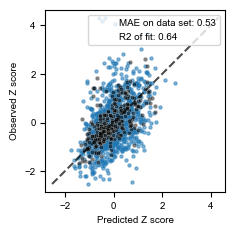

In [39]:
group_cols = ['DNA_name','Mg', 'SecYE', 'K', 'PEG','lipid']

obs_name = 'original_label'
pred_name = 'pred'

for ensemble,ensemble_df in test_converted[test_converted['ensemble'] == 'dna_encoded'].groupby(['ensemble','label_type']):
    mae_train = median_absolute_error(ensemble_df[obs_name], ensemble_df[pred_name])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ensemble_df[pred_name], ensemble_df[obs_name])
    
    t = ensemble_df.groupby(group_cols)[[obs_name,pred_name]].agg('mean')
    slope_mean, intercept_mean, r_value_mean, p_value_mean, std_err_mean = scipy.stats.linregress(t[pred_name], t[obs_name])
    print(f'R_value for all:{r_value}')
    scores = {
        "MAE on data set": f"{mae_train:.2f}",
        "R2 of fit": f"{r_value_mean:.2f}",
    }

    fig,ax = plt.subplots(figsize=[6*cm,6*cm])
    display = PredictionErrorDisplay.from_predictions(
        ensemble_df[obs_name], ensemble_df[pred_name], kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5,'s':5}
    )
    
    sns.scatterplot(data=t.sample(300),x=pred_name,y=obs_name,color='black',alpha=0.5,s=10)
    
    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper right")
    plt.xticks([-2,0,2,4])
    plt.yticks([-2,0,2,4])
    plt.tight_layout()
    plt.xlabel('Predicted Z score')
    plt.ylabel('Observed Z score')

    # plt.savefig(f'{fig_folder}/Fig3B-pred_vs_actual-Prot_ids.svg',format='svg',dpi=300)
    plt.show()

# ensemble_df[['ensemble', 'model_id', 'DNA_name', 'rxn_id', 'lipid', 'Mg', 'SecYE',
#        'K', 'PEG', 'pmol', 'pmol_sub','pred','original_value', 'original_label', 'converted_pred']].set_index('ensemble').to_excel(f'{data_folder}/Fig3B-prot_id_predictions.xlsx')

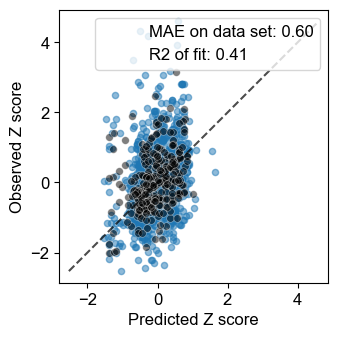

In [40]:
plt.rcParams['font.size'] = 12

group_cols = ['DNA_name','Mg', 'SecYE', 'K', 'PEG','lipid']

obs_name = 'original_label'
pred_name = 'pred'

for ensemble,ensemble_df in test_converted[test_converted['ensemble'] == 'no_prot_features'].groupby(['ensemble','label_type']):
    mae_train = median_absolute_error(ensemble_df[obs_name], ensemble_df[pred_name])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ensemble_df[pred_name], ensemble_df[obs_name])
    
    t = ensemble_df.groupby(group_cols)[[obs_name,pred_name]].agg('mean')
    slope_mean, intercept_mean, r_value_mean, p_value_mean, std_err_mean = scipy.stats.linregress(t[pred_name], t[obs_name])
    
    scores = {
        "MAE on data set": f"{mae_train:.2f}",
        "R2 of fit": f"{r_value_mean:.2f}",
    }

    fig,ax = plt.subplots(figsize=[9*cm,9*cm])
    display = PredictionErrorDisplay.from_predictions(
        ensemble_df[obs_name], ensemble_df[pred_name], kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5,'s':20}
    )
    
    sns.scatterplot(data=t.sample(300),x=pred_name,y=obs_name,color='black',alpha=0.5,s=30)
    
    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper right")
    plt.xticks([-2,0,2,4])
    plt.yticks([-2,0,2,4])
    plt.tight_layout()
    plt.xlabel('Predicted Z score')
    plt.ylabel('Observed Z score')

    # plt.savefig(f'{fig_folder}/Supp_fig-pred_vs_actual-rxn_features.svg',format='svg',dpi=300)
    plt.show()
    
# ensemble_df[['ensemble', 'model_id', 'DNA_name', 'rxn_id', 'lipid', 'Mg', 'SecYE',
#        'K', 'PEG', 'pmol', 'pmol_sub','pred','original_value', 'original_label', 'converted_pred']].set_index('ensemble').to_excel(f'{data_folder}/Supp_fig-rxn_feature_predictions.xlsx')
plt.rcParams['font.size'] = 7


### Investigate the ensemble performance on individual proteins

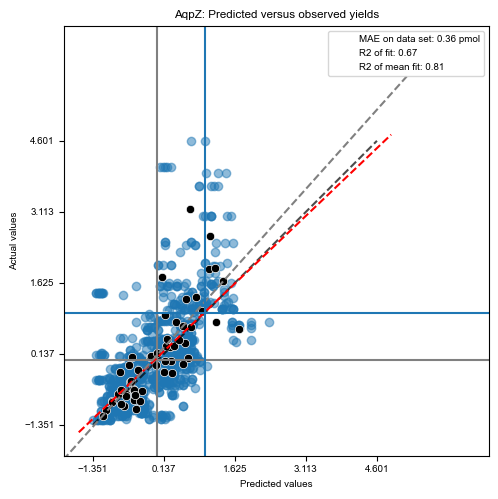

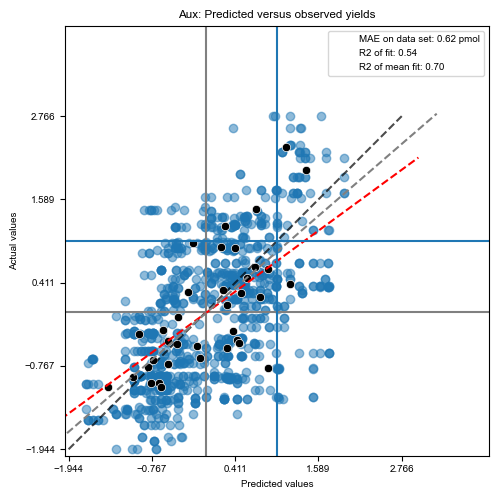

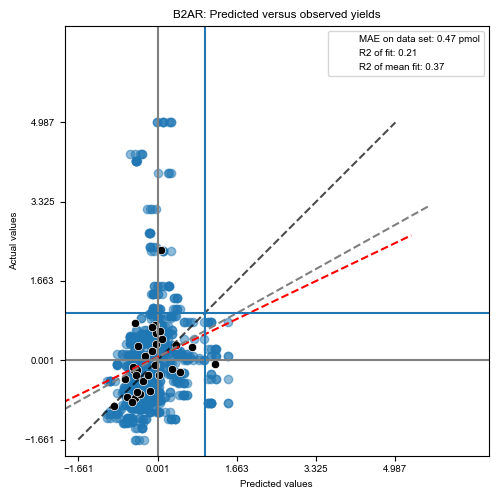

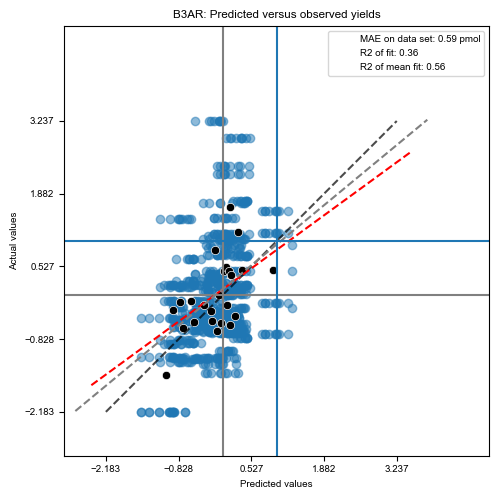

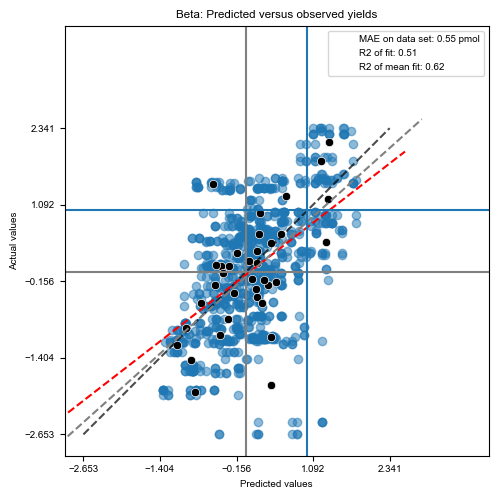

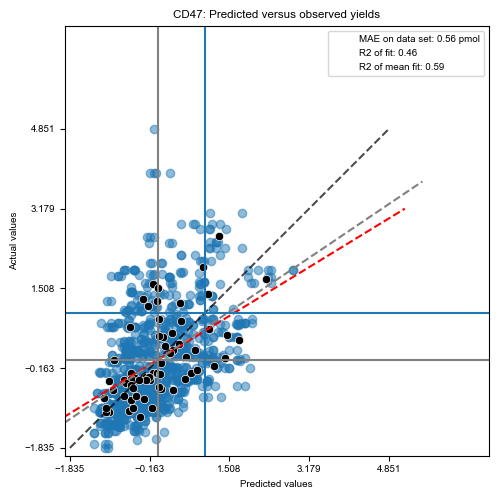

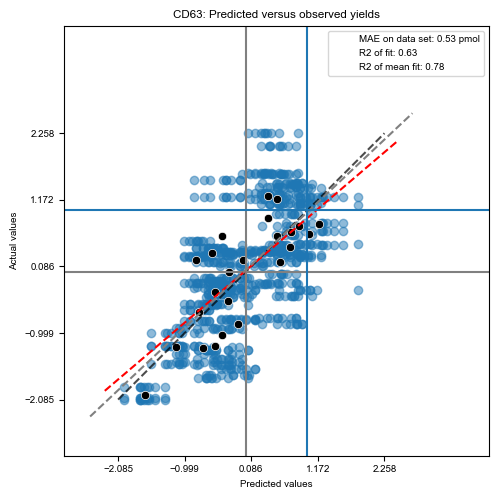

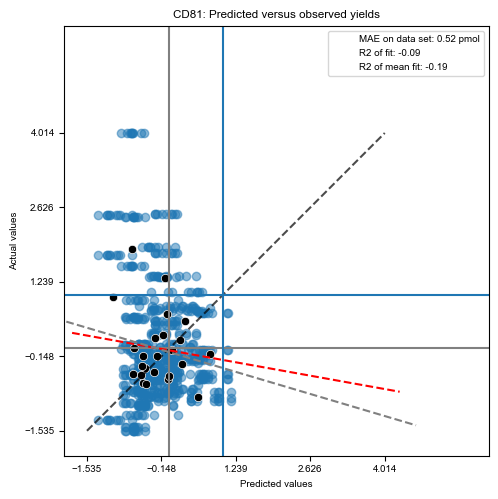

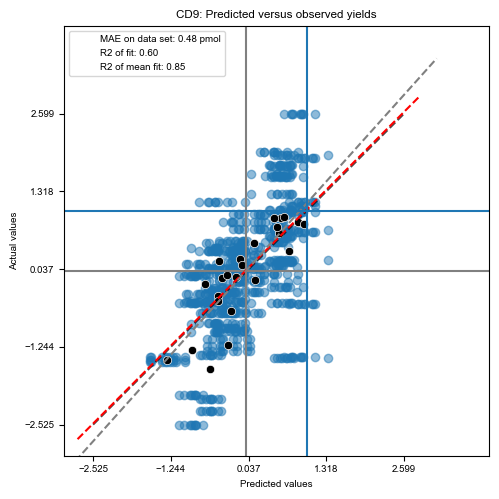

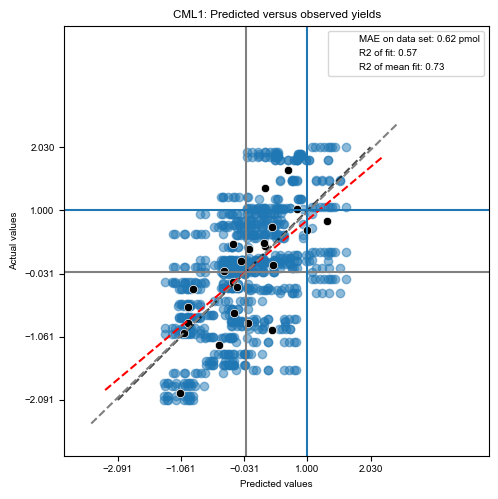

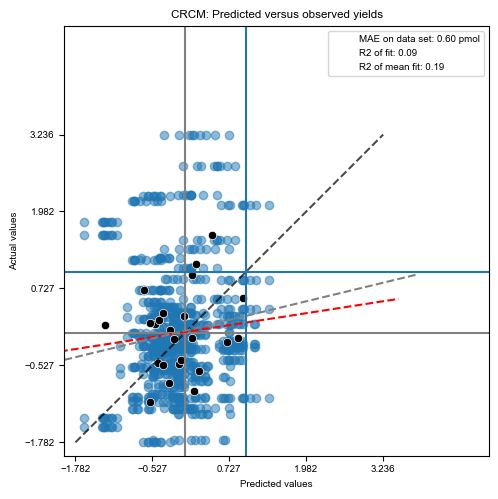

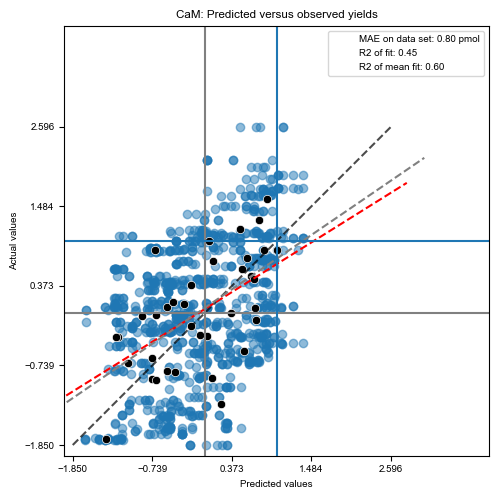

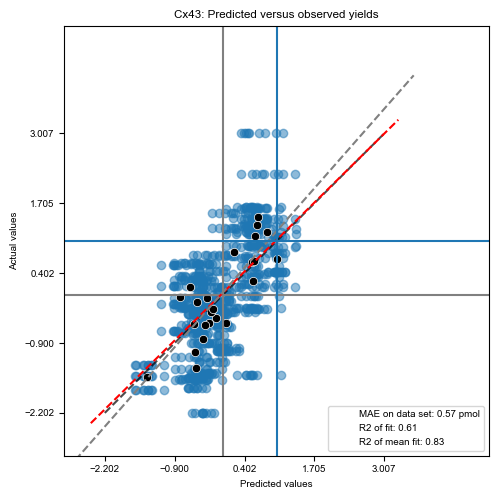

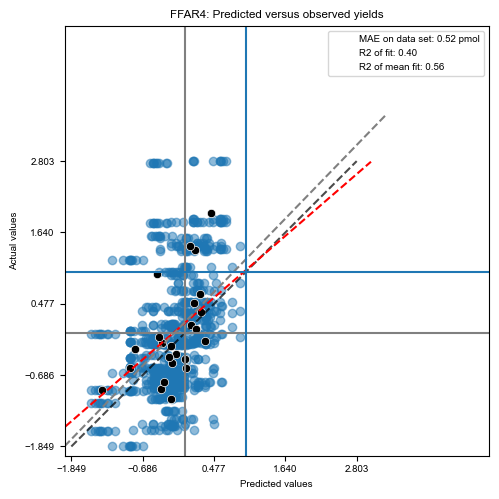

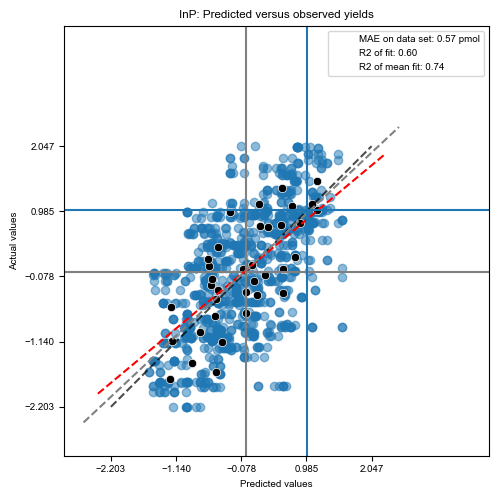

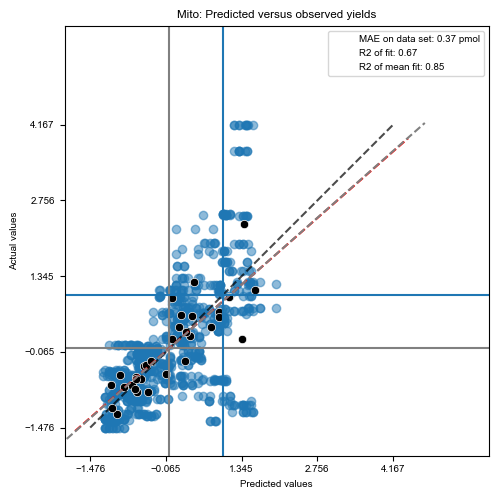

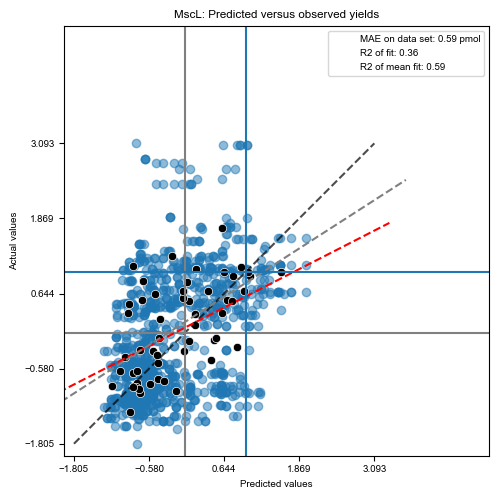

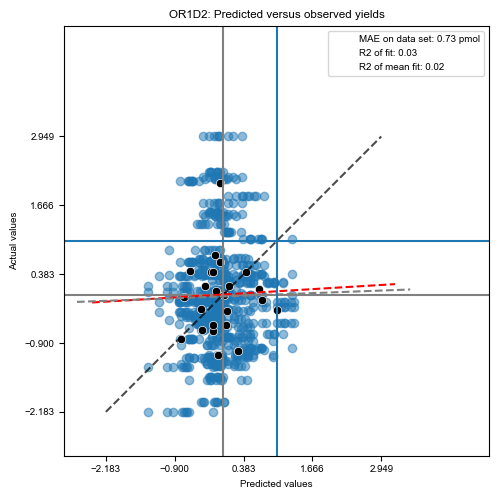

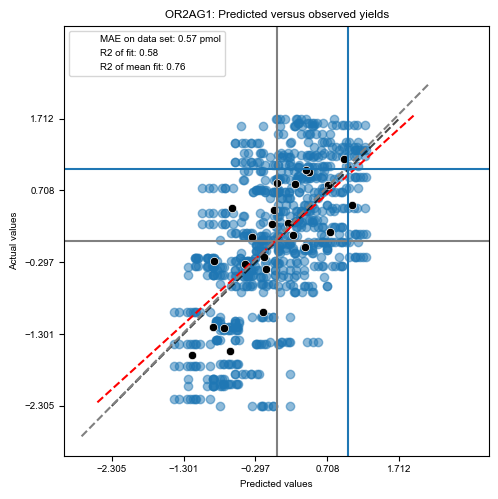

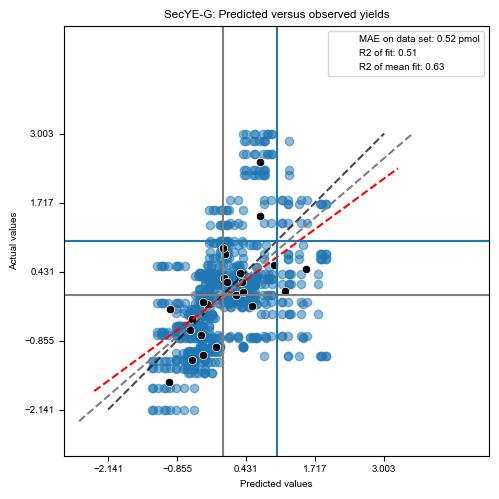

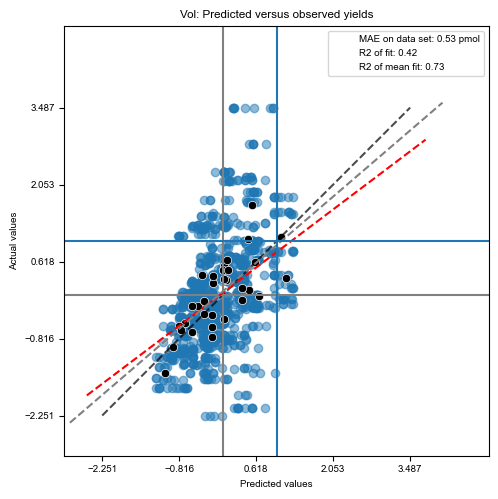

In [42]:
group_cols = ['DNA_name','Mg', 'SecYE', 'K', 'PEG','lipid']

obs_name = 'original_label'
pred_name = 'pred'

all_r_vals = []

temp = test_converted[test_converted['ensemble'] == 'dna_encoded']
for dna,dna_df in temp.groupby('DNA_name'):
    mae_train = median_absolute_error(dna_df[obs_name], dna_df[pred_name])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dna_df[pred_name], dna_df[obs_name])
    
    t = dna_df.groupby(group_cols)[[obs_name,pred_name]].agg('mean')
    slope_mean, intercept_mean, r_value_mean, p_value_mean, std_err_mean = scipy.stats.linregress(t[pred_name], t[obs_name])
    
    def abline(slope, intercept,ax,color='red'):
        """Plot a line from slope and intercept"""
        axes = plt.gca()
        x_vals = np.array(axes.get_xlim())
        y_vals = intercept + slope * x_vals
        ax.plot(x_vals, y_vals, '--',color=color)

    scores = {
        "MAE on data set": f"{mae_train:.2f} pmol",
        "R2 of fit": f"{r_value:.2f}",
        "R2 of mean fit": f"{r_value_mean:.2f}",
    }

    _, ax = plt.subplots(figsize=(5, 5))
    display = PredictionErrorDisplay.from_predictions(
        dna_df[obs_name], dna_df[pred_name], kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
    )
    ax.set_title(f"{dna}: Predicted versus observed yields")
    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")
    plt.tight_layout()
    # plt.plot([-5,25],[-5,25],color='black',ls='--')
    plt.axvline(0,color='grey')
    plt.axhline(0,color='grey')
    abline(slope, intercept,ax)
    upper = round(np.max(dna_df[obs_name])*1.25)+1
    lower = round(np.min(dna_df[obs_name])*0.75)-1
    # upper = 10
    # lower = 0
    
    sns.scatterplot(data=t,x=pred_name,y=obs_name,color='black')
    abline(slope_mean, intercept_mean,ax,color='grey')
    plt.xlim([lower,upper])
    plt.ylim([lower,upper])
    plt.axvline(1)
    plt.axhline(1)
    
    plt.show()
    
    all_r_vals.append([dna,r_value,r_value_mean])
    
# all_r_vals = pd.concat(all_r_vals)
# all_r_vals

# Compare the active learning reactions to the screening data

## Prepare data for analysis

In [12]:
data = pd.read_pickle('../all_data/General_data/screen_active_data.pkl')
data

experiment_id   day  plate well_name Supp DNA_name  DNA_conc  \
0            eCM313 1.000  1.000       H12  S22     AqpZ     5.000   
1            eCM313 1.000  1.000       K12  S22     AqpZ     5.000   
2            eCM313 1.000  1.000        M5  S22     AqpZ     5.000   
3            eCM313 2.000  4.000        J2  S22     AqpZ     5.000   
4            eCM313 2.000  4.000       N22  S22     AqpZ     5.000   
...             ...   ...    ...       ...  ...      ...       ...   
33542        eCM313 2.000  3.000        A1  S22      Vol     5.000   
33543        eCM313 2.000  4.000        B2  S22      Vol     5.000   
33544        eCM313 2.000  4.000        B2  S22      Vol     5.000   
33545        eCM313 2.000  4.000        G6  S22      Vol     5.000   
33546        eCM313 2.000  4.000        G6  S22      Vol     5.000   

      Liposome_name  Liposome_conc     Mg  SecYE    K   WCE   PEG  pmol  \
0              DMPC              3  8.000  0.000   85  BL62 2.000 4.918   
1              DMPC              3  8.000  0.000   85  BL62 2.000 4.311   
2              DMPC              3  8.000  0.000   85  BL62 2.000 2.644   
3              DMPC              3  8.000  0.000   85  BL62 2.000 7.546   
4              DMPC              3  8.000  0.000   85  BL62 2.000 7.527   
...             ...            ...    ...    ...  ...   ...   ...   ...   
33542       no_lipo              0 20.000  1.250  135  BL62 2.000 1.149   
33543       no_lipo              0 20.000  1.250  135  BL62 2.000 1.265   
33544       no_lipo              0 20.000  1.250  135  BL62 2.000 1.265   
33545       no_lipo              0 20.000  1.250  135  BL62 2.000 2.024   
33546       no_lipo              0 20.000  1.250  135  BL62 2.000 2.024   

        rxn_id   label  
0        0.000  screen  
1        0.000  screen  
2        0.000  screen  
3        0.000  screen  
4        0.000  screen  
...        ...     ...  
33542 3966.000  screen  
33543 3862.000  screen  
33544 3966.000  screen  
33545 3862.000  screen  
33546 3966.000  screen  

[11197 rows x 17 columns]

In [13]:
sub_df = []

for rxn_id,rxn_df in data.groupby('rxn_id'):
    lipo = rxn_df[rxn_df['Liposome_conc'] != 0].copy()
    nolipo = rxn_df[rxn_df['Liposome_conc'] == 0].copy()
    nolipo_mean = np.mean(nolipo['pmol'])
    if len(nolipo) == 0:
        print(rxn_id)
        continue
    lipo['pmol_sub'] = lipo['pmol'] - nolipo_mean
    nolipo['pmol_sub'] = nolipo['pmol'] - nolipo_mean
    
    sub_df.append(lipo)
    sub_df.append(nolipo)
    
sub_df = pd.concat(sub_df)
sub_df

experiment_id   day  plate well_name Supp DNA_name  DNA_conc  \
0            eCM313 1.000  1.000       H12  S22     AqpZ     5.000   
1            eCM313 1.000  1.000       K12  S22     AqpZ     5.000   
2            eCM313 1.000  1.000        M5  S22     AqpZ     5.000   
3            eCM313 2.000  4.000        J2  S22     AqpZ     5.000   
4            eCM313 2.000  4.000       N22  S22     AqpZ     5.000   
...             ...   ...    ...       ...  ...      ...       ...   
33538        eCM313 1.000  2.000       C22  S22      Vol     5.000   
33540        eCM313 1.000  2.000       N11  S22      Vol     5.000   
33542        eCM313 2.000  3.000        A1  S22      Vol     5.000   
33544        eCM313 2.000  4.000        B2  S22      Vol     5.000   
33546        eCM313 2.000  4.000        G6  S22      Vol     5.000   

      Liposome_name  Liposome_conc     Mg  SecYE    K   WCE   PEG  pmol  \
0              DMPC              3  8.000  0.000   85  BL62 2.000 4.918   
1              DMPC              3  8.000  0.000   85  BL62 2.000 4.311   
2              DMPC              3  8.000  0.000   85  BL62 2.000 2.644   
3              DMPC              3  8.000  0.000   85  BL62 2.000 7.546   
4              DMPC              3  8.000  0.000   85  BL62 2.000 7.527   
...             ...            ...    ...    ...  ...   ...   ...   ...   
33538       no_lipo              0 20.000  1.250  135  BL62 2.000 1.915   
33540       no_lipo              0 20.000  1.250  135  BL62 2.000 1.529   
33542       no_lipo              0 20.000  1.250  135  BL62 2.000 1.149   
33544       no_lipo              0 20.000  1.250  135  BL62 2.000 1.265   
33546       no_lipo              0 20.000  1.250  135  BL62 2.000 2.024   

        rxn_id   label  pmol_sub  
0        0.000  screen     2.688  
1        0.000  screen     2.081  
2        0.000  screen     0.414  
3        0.000  screen     5.316  
4        0.000  screen     5.297  
...        ...     ...       ...  
33538 3966.000  screen     0.238  
33540 3966.000  screen    -0.148  
33542 3966.000  screen    -0.529  
33544 3966.000  screen    -0.413  
33546 3966.000  screen     0.347  

[11197 rows x 18 columns]

## Calculate the difference in active learning and screening reaction populations for each protein
* Calculates the significance of the change to active learning using a t-test
* Defines significance as a p-value less than 0.05
* Identifies 21 proteins as significant

In [14]:
lipo_all = sub_df[sub_df['Liposome_name'] != 'no_lipo'].copy()
means = lipo_all.groupby('rxn_id')[['pmol','pmol_sub']].agg('mean')
lipo_all = means.join(lipo_all[['label','rxn_id','DNA_name','Mg','K','PEG','SecYE','Liposome_name','pmol','pmol_sub']].set_index('rxn_id'),lsuffix='_mean').drop_duplicates()

p_vals = []
for dna,dna_df in lipo_all.groupby('DNA_name'):
    a = dna_df[dna_df['label'] == 'active']
    s = dna_df[dna_df['label'] == 'screen']
    
    pval = -np.log(ttest_ind(a['pmol_sub'],s['pmol_sub'])[1])

    a_mean = a['pmol_sub'].mean()
    s_mean = s['pmol_sub'].mean()
    
    diff = a_mean - s_mean

    p_vals.append([dna,diff,pval])
    
p_vals = pd.DataFrame(p_vals,columns=['DNA_name','diff','pval'])
p_vals['pval'] = p_vals['pval'].clip(0,50)

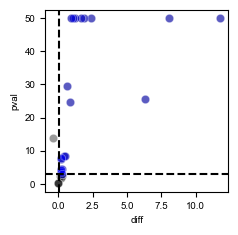

In [15]:
x_thresh = 0.1
y_thresh = -np.log(0.05)

fig,ax = plt.subplots(figsize=[6*cm,6*cm])

sns.scatterplot(data=p_vals,x='diff',y='pval',alpha=0.4,color='black')
sns.scatterplot(data=p_vals[(p_vals['diff'] > x_thresh) & (p_vals['pval'] > y_thresh)],x='diff',y='pval',alpha=0.4,color='blue')

plt.axvline(x_thresh,color='black',ls='--')
plt.axhline(y_thresh,color='black',ls='--')

plt.show()

In [16]:
sns.displot(data=p_vals,x='pval',bins=50)
plt.axvline(-np.log(0.05),color='k',ls='--')
plt.show()

In [17]:
significant = p_vals[p_vals['pval'] > -np.log(0.05)]['DNA_name'].tolist()
significant = [x for x in significant if x != 'Cx43']
len(significant)

21

In [18]:
high = ['AqpZ','MscL','Mito']

def assign_group(dna):
    if dna in high:
        return 'high'
    elif dna in significant:
        return 'significant'
    else:
        return 'insignificant'
    
lipo_all['group'] = lipo_all['DNA_name'].apply(assign_group)
lipo_all

pmol_mean  pmol_sub_mean   label DNA_name     Mg    K   PEG  SecYE  \
rxn_id                                                                         
0.000         5.389          3.159  screen     AqpZ  8.000   85 2.000  0.000   
0.000         5.389          3.159  screen     AqpZ  8.000   85 2.000  0.000   
0.000         5.389          3.159  screen     AqpZ  8.000   85 2.000  0.000   
0.000         5.389          3.159  screen     AqpZ  8.000   85 2.000  0.000   
0.000         5.389          3.159  screen     AqpZ  8.000   85 2.000  0.000   
...             ...            ...     ...      ...    ...  ...   ...    ...   
3966.000      1.263         -0.415  screen      Vol 20.000  135 2.000  1.250   
3966.000      1.263         -0.415  screen      Vol 20.000  135 2.000  1.250   
3966.000      1.263         -0.415  screen      Vol 20.000  135 2.000  1.250   
3966.000      1.263         -0.415  screen      Vol 20.000  135 2.000  1.250   
3966.000      1.263         -0.415  screen      Vol 20.000  135 2.000  1.250   

         Liposome_name  pmol  pmol_sub        group  
rxn_id                                               
0.000             DMPC 4.918     2.688         high  
0.000             DMPC 4.311     2.081         high  
0.000             DMPC 2.644     0.414         high  
0.000             DMPC 7.546     5.316         high  
0.000             DMPC 7.527     5.297         high  
...                ...   ...       ...          ...  
3966.000          DOPC 1.240    -0.438  significant  
3966.000          DOPC 1.230    -0.447  significant  
3966.000          DOPC 1.726     0.048  significant  
3966.000          DOPC 1.145    -0.532  significant  
3966.000          DOPC 0.972    -0.705  significant  

[5498 rows x 12 columns]

### Fig 3C - Plot the different reactions for both the screening and active learning reactions
* The average of each reaction composition is plotted instead of all replicates to make it possible to include all reactions conditions

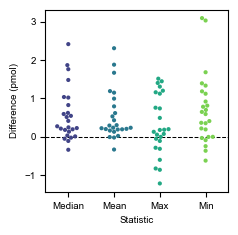

In [19]:
lipo_means = lipo_all.reset_index().drop_duplicates(subset='rxn_id').drop(columns=['pmol','pmol_sub']).rename(columns={'pmol_mean':'pmol','pmol_sub_mean':'pmol_sub'})

medians = lipo_means.groupby(['DNA_name','label'])[['pmol_sub']].agg('median')

medians = medians.unstack()
medians.columns = ['active','screen']
medians['diff'] = medians['active'] - medians['screen']
medians['percent'] = (medians['active'] - medians['screen']) / medians['screen']
medians['label'] = 'Median'

means = lipo_means.groupby(['DNA_name','label'])[['pmol_sub']].agg('mean')
means = means.unstack()
means.columns = ['active','screen']
means['diff'] = means['active'] - means['screen']
means['percent'] = (means['active'] - means['screen']) / means['screen']
means['label'] = 'Mean'

maxs = lipo_means.groupby(['DNA_name','label'])[['pmol_sub']].agg('max')
maxs = maxs.unstack()
maxs.columns = ['active','screen']
maxs['diff'] = maxs['active'] - maxs['screen']
maxs['percent'] = (maxs['active'] - maxs['screen']) / maxs['screen']
maxs['label'] = 'Max'

mins = lipo_means.groupby(['DNA_name','label'])[['pmol_sub']].agg('min')
mins = mins.unstack()
mins.columns = ['active','screen']
mins['diff'] = mins['active'] - mins['screen']
mins['percent'] = (mins['active'] - mins['screen']) / mins['screen']
mins['label'] = 'Min'

stdevs = lipo_means.groupby(['DNA_name','label'])[['pmol_sub']].agg('std')
stdevs = stdevs.unstack()
stdevs.columns = ['active','screen']
stdevs['diff'] = stdevs['active'] - stdevs['screen']
stdevs['percent'] = (stdevs['active'] - stdevs['screen']) / stdevs['screen']
stdevs['label'] = 'Stdev'

calcs = pd.concat([medians,means,maxs,mins]).reset_index()
calcs['percent'] = calcs['percent'].clip(-2,2)

meta = pd.read_excel('../all_data/General_data/protein_metadata.xlsx')
calcs = calcs.set_index('DNA_name').join(meta.set_index('DNA_name')).reset_index()

high = ['AqpZ','MscL','Mito']
fig,ax = plt.subplots(figsize=[6*cm,6*cm])

current = calcs[(~calcs['DNA_name'].isin(high))]

sns.swarmplot(data=current,x='label',y='diff',ax=ax,s=3,palette='viridis',hue='label',legend=False)
plt.axhline(0,c='k',ls='--',lw=0.75)
plt.xlabel('Statistic')
plt.ylabel('Difference (pmol)')
# plt.savefig(f'{fig_folder}/all_stats_comparison.svg',format='svg',dpi=300)
plt.show()


In [ ]:
t = lipo_means[lipo_means['group'] == 'high'].groupby(['DNA_name','label'])[['pmol_sub']].agg('median').reset_index()
t = t[t['label'] == 'active'].sort_values('pmol_sub')
high_dna_order = t['DNA_name'].tolist()

PROPS = {
    'boxprops':{'edgecolor':'black','facecolor':'#e0e0e0'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'flierprops':{'color':'none'}
}

current = lipo_means[lipo_means['DNA_name'].isin(high)]


fig,ax = plt.subplots(figsize=[3*cm,6*cm])

sns.stripplot(data=current,x='DNA_name',y='pmol_sub',hue='label',hue_order=['screen','active'],ax=ax,palette='Set1',order=high_dna_order[:],\
              dodge=True,edgecolor="black",linewidth=0.3,alpha=0.8,s=2,jitter=0.2)

sns.boxplot(data=current,x='DNA_name',y='pmol_sub',hue='label',ax=ax,\
            hue_order=['screen','active'],palette='Set1',order=high_dna_order[:],saturation=1,linewidth=0.75,**PROPS,fliersize=2,notch=False)

plt.axhline(0,c='k',ls='--',lw=0.5)
ax.get_legend().remove()
plt.xticks(rotation=45, ha='center')

# plt.savefig(f'{fig_folder}/Fig3C-active_boxplots_high_w_heat.svg',format='svg',dpi=300)

plt.show()
current.to_excel(f'{data_folder}/Fig3C-high_averages.xlsx')

In [21]:
current

rxn_id   pmol  pmol_sub   label DNA_name     Mg    K   PEG  SecYE  \
0       0.000  5.389     3.159  screen     AqpZ  8.000   85 2.000  0.000   
5       1.000 11.141     4.797  active     AqpZ  8.000   85 0.000  0.000   
9       2.000  7.279     4.039  screen     AqpZ  8.000   85 2.000  0.000   
13      3.000  5.387     3.832  screen     AqpZ  8.000  135 2.000  0.000   
19      4.000 12.344     7.516  active     AqpZ  8.000  135 0.000  0.000   
...       ...    ...       ...     ...      ...    ...  ...   ...    ...   
4199 3060.000 11.540     6.236  screen     MscL 20.000   85 2.000  1.250   
4205 3061.000 24.321    17.218  screen     MscL 20.000   85 2.000  1.250   
4209 3062.000 15.172    10.810  screen     MscL 20.000  135 2.000  1.250   
4215 3063.000 25.415    16.252  active     MscL 20.000  135 2.000  1.250   
4218 3064.000 24.445    14.804  screen     MscL 20.000  185 1.000  1.250   

     Liposome_name group  
0             DMPC  high  
5             DMPC  high  
9             DMPC  high  
13            DMPC  high  
19            DMPC  high  
...            ...   ...  
4199          DOPC  high  
4205          DOPC  high  
4209          DOPC  high  
4215          DOPC  high  
4218          DOPC  high  

[195 rows x 11 columns]

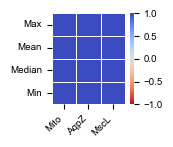

In [22]:
comps = calcs[['DNA_name','label','diff']].set_index(['DNA_name','label']).unstack()
comps.columns = comps.columns.droplevel()
comps = comps.T

comps = comps[high_dna_order]
fig,ax = plt.subplots(figsize=[3*cm,3*cm])

ax = sns.heatmap(comps,cmap='coolwarm_r',ax=ax,center=0,vmin=-1,vmax=1,linewidth=.5)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.xlabel('')
plt.ylabel('')
# plt.savefig(f'{fig_folder}/Fig3C-changes-high-heatmap.svg',format='svg',dpi=300)

plt.show()

# comps.to_excel(f'{data_folder}/Fig3C-High_active_heatmap.xlsx')

In [23]:
comps

DNA_name   Mito   AqpZ  MscL
label                       
Max      13.365 11.446 5.619
Mean      7.854 11.370 5.730
Median    7.403 11.007 7.165
Min       4.594  4.475 4.762

In [24]:
calcs

DNA_name  active  screen   diff  percent   label uniprot     Organism  \
0       AqpZ  14.064   3.057 11.007    2.000  Median  P60844      E. coli   
1        Aux   0.764  -0.060  0.824   -2.000  Median  F4HWB6  A. thaliana   
2       B2AR   0.160  -0.250  0.411   -1.641  Median  P07550   H. sapiens   
3       B3AR   0.230   0.038  0.192    2.000  Median  P13945   H. sapiens   
4       Beta   2.524   0.109  2.416    2.000  Median  Q9LTG0  A. thaliana   
..       ...     ...     ...    ...      ...     ...     ...          ...   
107    OR1D2  -0.281  -0.632  0.350   -0.555     Min  P34982   H. sapiens   
108    OR1E1  -0.484  -0.673  0.189   -0.280     Min  P30953   H. sapiens   
109   OR2AG1  -0.703  -0.334 -0.368    1.102     Min  Q9H205   H. sapiens   
110  SecYE-G  -0.017   0.018 -0.035   -1.941     Min  P0AGA2      E. coli   
111      Vol  -0.024  -1.145  1.121   -0.979     Min  Q5JW98   H. sapiens   

     Length  tm_count   Mass  
0       231         6 23.703  
1       472        10 51.877  
2       413         7 46.459  
3       408         7 43.519  
4       303         4 33.777  
..      ...       ...    ...  
107     312         7 35.240  
108     314         7 35.264  
109     316         7 35.270  
110     443        12 48.512  
111     314         4 35.060  

[112 rows x 11 columns]

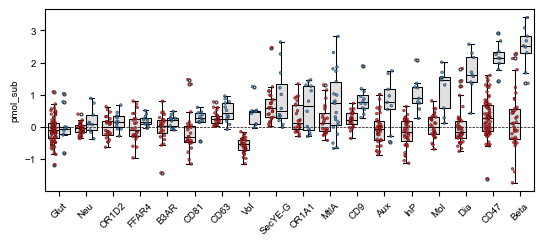

In [58]:
t = lipo_means[lipo_means['group'] == 'significant'].groupby(['DNA_name','label'])[['pmol_sub']].agg('median').reset_index()

t = t[t['label'] == 'active'].sort_values('pmol_sub')
sig_dna_order = t['DNA_name'].tolist()

fig,ax = plt.subplots(figsize=[16*cm,6*cm])
PROPS = {
    'boxprops':{'edgecolor':'black','facecolor':'#e0e0e0'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'flierprops':{'color':'none'}
}
current = lipo_means[lipo_means['group'] == 'significant']

sns.stripplot(data=current,x='DNA_name',y='pmol_sub',hue='label',hue_order=['screen','active'],ax=ax,palette='Set1',order=sig_dna_order[:],\
              dodge=True,edgecolor="black",linewidth=0.3,alpha=0.8,s=2,jitter=0.2)

sns.boxplot(data=current,x='DNA_name',y='pmol_sub',hue='label',ax=ax,\
            hue_order=['screen','active'],palette='Set1',order=sig_dna_order[:],saturation=1,linewidth=0.75,**PROPS,fliersize=2,notch=False)

plt.axhline(0,c='k',ls='--',lw=0.5)
ax.get_legend().remove()
plt.xticks(rotation=45, ha='center')
plt.xlabel('')

# plt.savefig(f'{fig_folder}/Fig_3C-active_boxplots_sign-w_heat.svg',format='svg',dpi=300)
plt.show()
# current.to_excel(f'{data_folder}/Fig3C-significant_averages.xlsx')

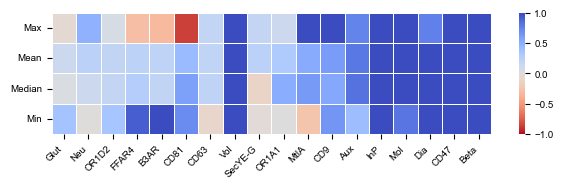

In [59]:
comps = calcs[['DNA_name','label','diff']].set_index(['DNA_name','label']).unstack()
comps.columns = comps.columns.droplevel()
comps = comps.T
comps = comps[sig_dna_order]
fig,ax = plt.subplots(figsize=[18*cm,4*cm])

ax = sns.heatmap(comps,cmap='coolwarm_r',ax=ax,center=0,vmin=-1,vmax=1,linewidth=.5)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.xlabel('')
plt.ylabel('')
# plt.savefig(f'{fig_folder}/Fig3C-changes-heatmap.svg',format='svg',dpi=300)

plt.show()
# comps.to_excel(f'{data_folder}/Fig3C-Significant_active_heatmap.xlsx')

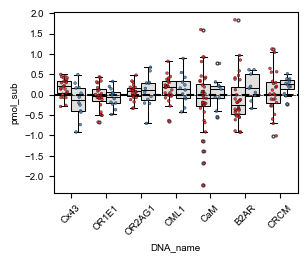

In [60]:
t = lipo_means[lipo_means['group'] == 'insignificant'].groupby(['DNA_name','label'])[['pmol_sub']].agg('median').reset_index()
t = t[t['label'] == 'active'].sort_values('pmol_sub')
insig_dna_order = t['DNA_name'].tolist()

fig,ax = plt.subplots(figsize=[8*cm,6*cm])

current = lipo_means[lipo_means['group'] == 'insignificant']

sns.stripplot(data=current,x='DNA_name',y='pmol_sub',hue='label',hue_order=['screen','active'],ax=ax,palette='Set1',order=insig_dna_order[:],\
              dodge=True,edgecolor="black",linewidth=0.3,alpha=0.8,s=2,jitter=0.2)

sns.boxplot(data=current,x='DNA_name',y='pmol_sub',hue='label',ax=ax,\
            hue_order=['screen','active'],palette='Set1',order=insig_dna_order[:],saturation=1,linewidth=0.75,**PROPS,fliersize=2,notch=False)

plt.axhline(0,c='k',ls='--',lw=0.5)
ax.get_legend().remove()
plt.xticks(rotation=45, ha='center')

plt.axhline(0,c='k',ls='--')
# plt.savefig(f'{fig_folder}/Supp_fig-active_boxplots_insignificant.svg',format='svg',dpi=300)

plt.show()
# current.to_excel(f'{data_folder}/Supp_Fig-Insignificant_averages.xlsx')

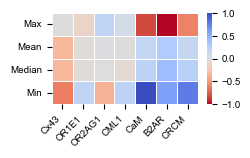

In [61]:
comps = calcs[['DNA_name','label','diff']].set_index(['DNA_name','label']).unstack()
comps.columns = comps.columns.droplevel()
comps = comps.T
comps = comps[insig_dna_order]
fig,ax = plt.subplots(figsize=[6*cm,3*cm])

ax = sns.heatmap(comps,cmap='coolwarm_r',ax=ax,center=0,vmin=-1,vmax=1,linewidth=.5)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.xlabel('')
plt.ylabel('')
# plt.savefig(f'{fig_folder}/Supp_fig-changes-insign-heatmap.svg',format='svg',dpi=300)

plt.show()

# comps.to_excel(f'{data_folder}/Supp_Fig-insignificant_active_heatmap.xlsx')

### Fig 3D - Calculate trajectories between the standard and best performing reaction composition
* Extract the reaction ids for the standard reactions and the top performing for each protein
* Normalize the reaction component concentrations and the resulting yields
    * A min-max scaler is used on the yield so that it always sets the highest value to one and then the standard reaction is some fraction of it
* Calculate the Euclidean distance between each reaction component concentration and the different yields

In [62]:
standard = {
    'Mg':[12,14],
    'K':[85],
    'PEG':[2],
    'Liposome_name':['DOPC'],
    'SecYE':[0],
}

standard_df = lipo_means.copy()
for key in standard.keys():
    standard_df = standard_df[standard_df[key].isin(standard[key])]
dup = standard_df[(standard_df['DNA_name'].isin(['AqpZ','Glut','CD47','MscL']))]
non_dup = standard_df[(~standard_df['DNA_name'].isin(['AqpZ','Glut','CD47','MscL']))]
dup = dup[dup['Mg'] == 14].copy()
standard_df = pd.concat([non_dup,dup])
standard_df = standard_df[['rxn_id','DNA_name','Mg','K','PEG','Liposome_name','SecYE','pmol_sub']]

temp_df = []
temp_array = []
for dna,dna_df in standard_df.groupby('DNA_name'):
    if len(dna_df) == 1:
        temp_df.append(dna_df)
    else:
        mean = np.mean(dna_df['pmol_sub'])
        t = dna_df.copy()
        t['pmol_sub'] = mean
        t = t.iloc[0]
        temp_array.append(t)
standard_df = pd.concat(temp_df)
temp_array = pd.DataFrame(temp_array)

standard_df = pd.concat([standard_df,temp_array])
len(standard_df['DNA_name'].unique())
standard_ids = standard_df[['rxn_id','DNA_name']]
standard_df

rxn_id DNA_name     Mg   K   PEG Liposome_name  SecYE  pmol_sub
261    66.000     AqpZ 14.000  85 2.000          DOPC  0.000     6.647
468   189.000      Aux 14.000  85 2.000          DOPC  0.000    -0.591
694   400.000     B2AR 12.000  85 2.000          DOPC  0.000     0.473
862   562.000     B3AR 14.000  85 2.000          DOPC  0.000     0.128
990   655.000     Beta 14.000  85 2.000          DOPC  0.000     0.274
...       ...      ...    ...  ..   ...           ...    ...       ...
5103 3602.000   OR2AG1 14.000  85 2.000          DOPC  0.000     0.105
5408 3915.000      Vol 12.000  85 2.000          DOPC  0.000    -0.674
1966 1468.000     CML1 14.000  85 2.000          DOPC  0.000     0.172
2803 2150.000    FFAR4 14.000  85 2.000          DOPC  0.000     0.379
5240 3682.000  SecYE-G 14.000  85 2.000          DOPC  0.000     1.166

[28 rows x 8 columns]

In [63]:
best = []

for dna,dna_df in lipo_means.groupby('DNA_name'):
    best.append(dna_df.sort_values('pmol_sub',ascending=False).iloc[0])
best = pd.DataFrame(best)
best = best[['rxn_id','DNA_name','Mg','K','PEG','Liposome_name','SecYE','pmol_sub']]
best_ids = best[['rxn_id','DNA_name']]

In [64]:
best_ids

rxn_id DNA_name
176    39.000     AqpZ
360   138.000      Aux
750   457.000     B2AR
800   532.000     B3AR
1042  697.000     Beta
...       ...      ...
4834 3436.000    OR1D2
4937 3508.000    OR1E1
5139 3618.000   OR2AG1
5250 3685.000  SecYE-G
5442 3935.000      Vol

[28 rows x 2 columns]

In [65]:
all_features = lipo_means.copy()

lipo_dict = {'DOPC':18,'DPPC':16,'DMPC':14,'no_lipo':0}
all_features['lipid'] = all_features['Liposome_name'].apply(lambda x: lipo_dict[x])
all_features

data_bounded = all_features[['Mg', 'SecYE', 'K', 'PEG','lipid']]
X_bounded = np.array(data_bounded)
MMscalerX = MinMaxScaler()

X_bounded = MMscalerX.fit_transform(X_bounded)
data_bounded = pd.DataFrame(X_bounded,columns=data_bounded.columns)
data_bounded['rxn_id'] = all_features['rxn_id'].tolist()
data_bounded = data_bounded.set_index('rxn_id')
data_bounded

Mg  SecYE     K   PEG  lipid
rxn_id                                  
0.000    0.000  0.000 0.000 1.000  0.000
1.000    0.000  0.000 0.000 0.000  0.000
2.000    0.000  0.000 0.000 1.000  0.000
3.000    0.000  0.000 0.500 1.000  0.000
4.000    0.000  0.000 0.500 0.000  0.000
...        ...    ...   ...   ...    ...
3953.000 1.000  0.000 0.500 1.000  1.000
3954.000 1.000  0.000 1.000 0.000  1.000
3964.000 1.000  0.500 1.000 0.000  1.000
3965.000 1.000  1.000 0.000 1.000  1.000
3966.000 1.000  1.000 0.500 1.000  1.000

[1251 rows x 5 columns]

In [66]:
y_col = 'pmol_sub'

transformed = []
scaler_dict = {}

all_features = lipo_means.copy()
all_features
for dna, dna_df in all_features.groupby('DNA_name'):
    temp = dna_df.copy()
    y_scaled = np.array(temp[[y_col]])
    scalerY = MinMaxScaler()
    y_scaled = scalerY.fit_transform(y_scaled)
    temp['pmol_sub'] = y_scaled
    transformed.append(temp)
    scaler_dict.update({dna:scalerY})
transformed = pd.concat(transformed)
transformed = transformed[['rxn_id',y_col]].set_index('rxn_id')
transformed

pmol_sub
rxn_id            
0.000        0.131
1.000        0.207
2.000        0.172
3.000        0.162
4.000        0.333
...            ...
3953.000     0.358
3954.000     0.513
3964.000     0.676
3965.000     0.322
3966.000     0.304

[1251 rows x 1 columns]

In [67]:
norm_data = data_bounded.join(transformed).reset_index()
norm_data

rxn_id    Mg  SecYE     K   PEG  lipid  pmol_sub
0       0.000 0.000  0.000 0.000 1.000  0.000     0.131
1       1.000 0.000  0.000 0.000 0.000  0.000     0.207
2       2.000 0.000  0.000 0.000 1.000  0.000     0.172
3       3.000 0.000  0.000 0.500 1.000  0.000     0.162
4       4.000 0.000  0.000 0.500 0.000  0.000     0.333
...       ...   ...    ...   ...   ...    ...       ...
1246 3953.000 1.000  0.000 0.500 1.000  1.000     0.358
1247 3954.000 1.000  0.000 1.000 0.000  1.000     0.513
1248 3964.000 1.000  0.500 1.000 0.000  1.000     0.676
1249 3965.000 1.000  1.000 0.000 1.000  1.000     0.322
1250 3966.000 1.000  1.000 0.500 1.000  1.000     0.304

[1251 rows x 7 columns]

In [68]:
def calc_trajectory(row):
    return np.sqrt(((row['value_final'] - row['value_init'])**2) + ((row['pmol_sub_final'] - row['pmol_sub_init'])**2))


final = best_ids.set_index('rxn_id').join(norm_data.set_index('rxn_id')).reset_index().drop(columns=['rxn_id'])
final = final.set_index(['DNA_name','pmol_sub']).stack().reset_index().rename(columns={'level_2':'variable',0:'value'})
final
initial = standard_ids.set_index('rxn_id').join(norm_data.set_index('rxn_id')).reset_index().drop(columns=['rxn_id'])
initial = initial.set_index(['DNA_name','pmol_sub']).stack().reset_index().rename(columns={'level_2':'variable',0:'value'})

comparison = initial.set_index(['DNA_name','variable']).join(final.set_index(['DNA_name','variable']),lsuffix='_init',rsuffix='_final').reset_index()
comparison['distance'] = comparison.apply(calc_trajectory,axis=1)
comparison

DNA_name variable  pmol_sub_init  value_init  pmol_sub_final  value_final  \
0       AqpZ       Mg          0.292       0.500           1.000        0.000   
1       AqpZ    SecYE          0.292       0.000           1.000        0.000   
2       AqpZ        K          0.292       0.000           1.000        0.500   
3       AqpZ      PEG          0.292       1.000           1.000        0.000   
4       AqpZ    lipid          0.292       1.000           1.000        1.000   
..       ...      ...            ...         ...             ...          ...   
135  SecYE-G       Mg          0.426       0.500           1.000        0.500   
136  SecYE-G    SecYE          0.426       0.000           1.000        0.000   
137  SecYE-G        K          0.426       0.000           1.000        1.000   
138  SecYE-G      PEG          0.426       1.000           1.000        0.500   
139  SecYE-G    lipid          0.426       1.000           1.000        1.000   

     distance  
0       0.866  
1       0.708  
2       0.866  
3       1.225  
4       0.708  
..        ...  
135     0.574  
136     0.574  
137     1.153  
138     0.761  
139     0.574  

[140 rows x 7 columns]

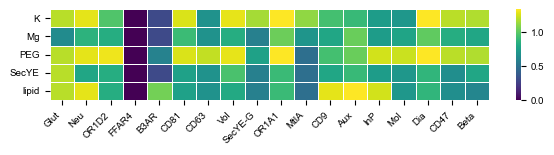

In [69]:
heat_comp = comparison[['DNA_name','variable','distance']].set_index(['DNA_name','variable']).unstack().T.reset_index()
heat_comp = heat_comp.drop(columns=['level_0']).set_index('variable')

heat_comp = heat_comp[sig_dna_order]

fig,ax = plt.subplots(figsize=[18*cm,3*cm])
ax = sns.heatmap(heat_comp,cmap='viridis',ax=ax,linewidth=.5,vmin=0,vmax=1.33)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.xlabel('')
plt.ylabel('')
# plt.savefig(f'{fig_folder}/Fig3D-trajectory_heatmap.svg',format='svg',dpi=300)

plt.show()
# heat_comp.to_excel(f'{data_folder}/Fig3D-significant_trajectory.xlsx')

In [70]:
heat_comp = comparison[['DNA_name','variable','distance']].set_index(['DNA_name','variable']).unstack().T.reset_index()
heat_comp = heat_comp.drop(columns=['level_0']).set_index('variable')

heat_comp = heat_comp[high_dna_order]

fig,ax = plt.subplots(figsize=[3*cm,3*cm])
ax = sns.heatmap(heat_comp,cmap='viridis',ax=ax,linewidth=.5,vmin=0,vmax=1.33)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.xlabel('')
plt.ylabel('')
# plt.savefig(f'{fig_folder}/Fig3D-trajectory_heatmap_high.svg',format='svg',dpi=300)

plt.show()
# heat_comp.to_excel(f'{data_folder}/Fig3D-high_trajectory.xlsx')

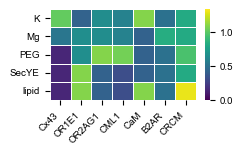

In [71]:
heat_comp = comparison[['DNA_name','variable','distance']].set_index(['DNA_name','variable']).unstack().T.reset_index()
heat_comp = heat_comp.drop(columns=['level_0']).set_index('variable')

heat_comp = heat_comp[insig_dna_order]

fig,ax = plt.subplots(figsize=[6*cm,3*cm])
ax = sns.heatmap(heat_comp,cmap='viridis',ax=ax,linewidth=.5,vmin=0,vmax=1.33)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.xlabel('')
plt.ylabel('')
# plt.savefig(f'{fig_folder}/Supp_fig-trajectory_heatmap_insig.svg',format='svg',dpi=300)

plt.show()
# heat_comp.to_excel(f'{data_folder}/Supp_Fig-insignificant_trajectory.xlsx')

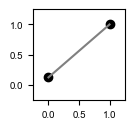

In [72]:
fig,ax = plt.subplots(figsize=[3*cm,3*cm])

t = comparison.copy()
t = t[(t['DNA_name'] == 'Dia') & (t['variable'] == 'K')].iloc[0]
pmol = [t['pmol_sub_init'],t['pmol_sub_final']]
conc = [t['value_init'],t['value_final']]

ax.plot(conc,pmol,color='grey')
ax.scatter(conc,pmol,color='k')
plt.xlim([-0.25,1.25])
plt.ylim([-0.25,1.25])
# plt.savefig(f'{fig_folder}/Fig3D-trajectory_explanation.svg',format='svg',dpi=300)

plt.show()

### Comparisons

In [73]:
heat_comp = comparison[['DNA_name','variable','distance']].set_index(['DNA_name','variable']).unstack().T.reset_index()
heat_comp = heat_comp.drop(columns=['level_0']).set_index('variable')

heat_comp.mean(axis=1)

variable
K       0.913
Mg      0.725
PEG     0.964
SecYE   0.670
lipid   0.795
dtype: float64